# Basic imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:
import master_functions as mf

In [3]:
# df_all = pd.read_csv('test/df_all.tsv', sep='\t')
df_all_small = pd.read_csv('test/dfs&results/df_all_small.tsv', sep='\t')
learning_df = pd.read_csv('test/dfs&results/learning_df.tsv', sep='\t')
# results = load('test/results.joblib')
results_small = load('test/dfs&results/results_small.joblib')

In [3]:
df_all_small.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.870,0.130
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.730,0.270
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.805,0.195
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.875,0.125
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.800,0.200


In [4]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

logo = LeaveOneGroupOut()
X_main = df_all_small.drop(['virus', 'host', 'group', 'group_code', 'y', '0', '1'], axis=1)
y_main = df_all_small['y']
groups_main = df_all_small['group_code'].values

# pandas-profiling

In [ ]:
# !!! requires Pandas 1.3.5 - incompatible with >= 1.4.0 because of indexing !!!
'''
from pandas_profiling import ProfileReport
profile = ProfileReport(df_all_small.drop(['0', '1'], axis=1), title='Bacteriophage interactions (Edwards) dataset')
profile.to_file('Edwards_analysis.html')
'''

# Feature selection

## Determining multicollinearity

#### VIF - Variance Inflation Factor

Define the vif function

In [6]:
feats = list(X_main.columns)
print(mf.calculate_vif(feats, df_all_small))

                 features  vif_Factor
0                  blastn    8.871166
1  crisprdetect-2mismatch    6.662138
2              gc_content   33.401111
3                     k25    8.853917
4            k6-chebyshev    4.177338
5           k6-kendalltau   54.389713
6            k6-manhattan  129.992448
7         piler-2mismatch    6.658734
8                    wish   23.329448
9                       y    1.160475


## Variable selection

### Simple selection - minimal set 

In [11]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
print(mf.calculate_vif(feats))

       features  vif_Factor
0        blastn    1.127404
1    gc_content    2.668067
2  k6-chebyshev    2.669262
3             y    1.128129


#### Train model on selected features - functions declarations

IMPORTANT RESULTS CONTAINER!!!

In [5]:
results_dfs = {}

### Random Forest

In [74]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def train_rfc_on_features(features: list, name: str, n_est=200, calibrate: bool = False):
    # get X and y
    X_selected = learning_df[features]
    y_selected = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    # train the model
    # determine the scoring method
    scoring = ['f1']
    # create logo cv procedure
    logo = LeaveOneGroupOut()
    # create model
    rfc = RandomForestClassifier(n_estimators = n_est, criterion = 'entropy', 
                                max_depth=4, random_state=1)
    # evaluate model
    results_selected = cross_validate(rfc, X_selected.to_numpy(), y_selected, scoring=scoring, 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)
    
    if calibrate:
        for i,est in enumerate(results_selected['estimator']):
            results_selected['estimator'][i] = CalibratedClassifierCV(est, cv=3)
            results_selected['estimator'][i].fit(X_selected[learning_df['group_code'] != i].to_numpy(), y_selected[learning_df['group_code'] != i])

    # get the probabilities
    prob_df_sel = mf.get_probabilities(features, results_selected, df_all_small)
    '''
    X_sel_main = df_all_small[features]
    prob_df_sel = pd.DataFrame(index=range(len(df_all_small['y'])), columns=['0', '1'])
    prob_df_sel['0'] = prob_df_sel['0'].astype('float')
    prob_df_sel['1'] = prob_df_sel['1'].astype('float')
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        prob_df_sel.loc[mask_main, ['0', '1']] = \
            results_selected['estimator'][i].predict_proba(X_sel_main.loc[mask_main,:])
    '''

    # append the dataframe to results dict
    results_dfs[name] = pd.concat([df_all_small['y'], prob_df_sel], axis=1)
    return

Train the model

In [39]:
feats = X_main.columns
train_rfc_on_features(feats, 'rfc_no_calibration')

c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without featur

In [75]:
train_rfc_on_features(feats, 'rfc_calibrated', calibrate=True)

c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without featur

In [41]:
results_dfs.keys()

dict_keys(['linSVC_all', 'linSVC_minimal', 'linSVC_4_highest_corr', 'linSVC_all_normalizer', 'linSVC_minimal_normalizer', 'linSVC_4_highest_corr_normalizer', 'rfc_no_calibration', 'rfc_calibrated'])

In [42]:
df_rfc_uncalibrated = df_all_small.copy()
df_rfc_uncalibrated[['y', '0', '1']] = results_dfs['rfc_no_calibration']

In [43]:
df_rfc_calibrated = df_all_small.copy()
df_rfc_calibrated[['y', '0', '1']] = results_dfs['rfc_calibrated']

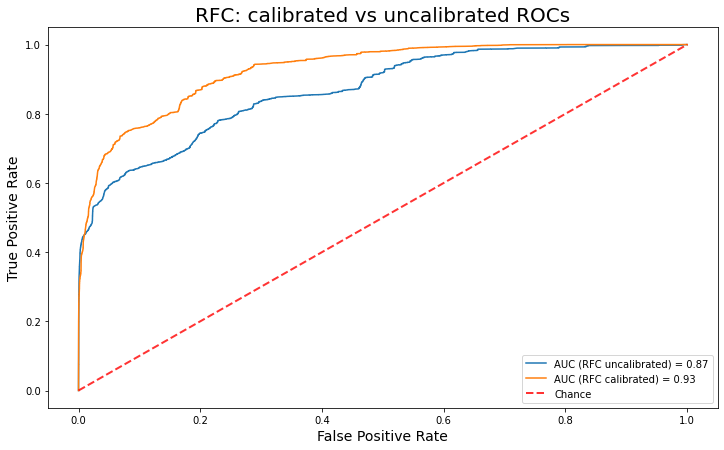

In [76]:
mf.draw_rocs(dfs=[
    df_rfc_uncalibrated,
    df_rfc_calibrated
    ],
    names=[
        'RFC uncalibrated',
        'RFC calibrated'
    ],
    plot_name='RFC: calibrated vs uncalibrated ROCs'
)

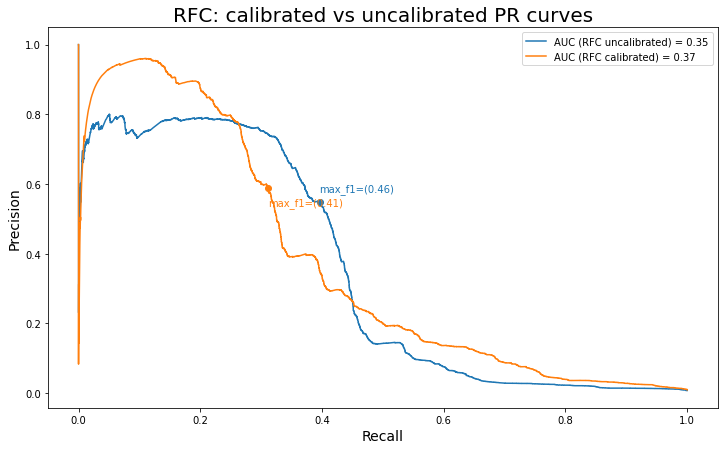

In [77]:
mf.draw_precision_recall_curve(dfs=[
    df_rfc_uncalibrated,
    df_rfc_calibrated
    ],
    names=[
        'RFC uncalibrated',
        'RFC calibrated'
    ],
    plot_name='RFC: calibrated vs uncalibrated PR curves'
)

In [78]:
orgs = mf.load_in_taxonomy_json()
dfs = [df_rfc_calibrated, df_rfc_uncalibrated]
names = ['RFC_calibrated', 'RFC_uncalibrated']
percentages_sampled_df = pd.DataFrame(index=names, columns=mf.get_correct_preds_percentages(df_rfc_calibrated, orgs, names[0]).columns)
percentages_sampled_df

,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
RFC_calibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RFC_uncalibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
for i, df in enumerate(dfs):
    percentages_sampled_df.loc[names[i]] = mf.get_correct_preds_percentages(df=df, orgs=orgs, row_name=names[i], report=True).values

percentages_sampled_df

RFC_calibrated - num of preds with highest prob: 1182, mean = 1.44
RFC_uncalibrated - num of preds with highest prob: 1182, mean = 1.44


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
RFC_calibrated,35.609756,54.756098,67.073171,72.439024,85.365854,90.731707,100.0
RFC_uncalibrated,35.609756,54.878049,67.073171,72.439024,85.243902,90.731707,100.0


In [71]:
from sklearn.calibration import calibration_curve
def draw_calibration_curve(df: pd.DataFrame, norm: bool = False):
    plt.figure(figsize=(8,8))
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        curr = df.loc[mask_main,:]
        # reliability diagram
        fop, mpv = calibration_curve(curr['y'], curr['1'], n_bins=10, normalize=norm)
        # plot perfectly calibrated
        plt.plot([0, 1], [0, 1], linestyle='--')
        # plot model reliability
        plt.plot(mpv, fop, marker='.')
    plt.show()

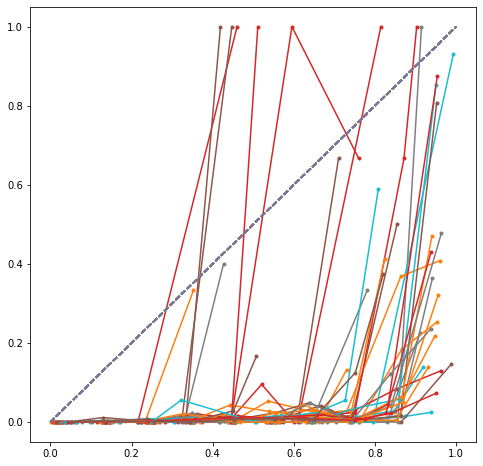

In [80]:
draw_calibration_curve(df_rfc_calibrated)

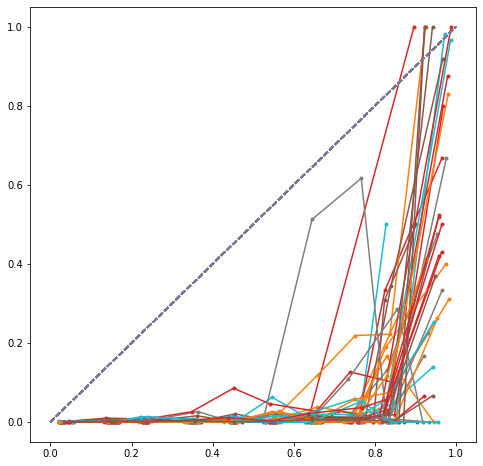

In [81]:
draw_calibration_curve(df_rfc_uncalibrated)

CONCLUSION: the model doesn't know about the disproportion of classes IRL (because of undersampling), so it'll happily assign too high a probability to observations

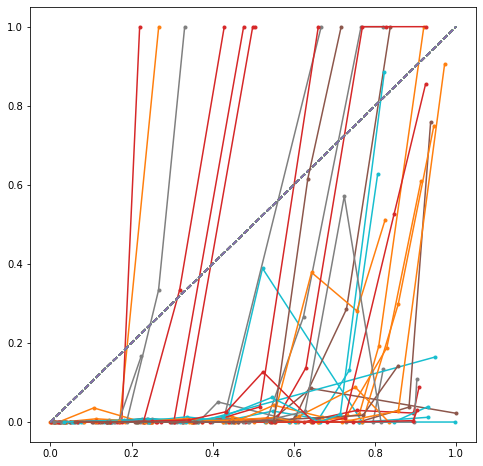

In [83]:
draw_calibration_curve(results_dfs['linSVC_all_normalizer'])

Train the model on minimal set

In [14]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_rfc_on_features(feats, 'rfc_minimal')

In [19]:
results_dfs['rfc_minimal'].head()

,y,0,1
0,1,0.338828,0.661172
1,1,0.291073,0.708927
2,1,0.323247,0.676753
3,1,0.347974,0.652026
4,1,0.323247,0.676753


#### Advanced selection

#### 1. Determine n feats with highest corr to label

In [24]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
corrs

k25                       0.334636
blastn                    0.333629
crisprdetect-2mismatch    0.118987
piler-2mismatch           0.116918
k6-manhattan              0.099880
wish                      0.094791
k6-kendalltau             0.087376
gc_content                0.083626
k6-chebyshev              0.055518
dtype: float64

In [25]:
feats = list(corrs.index[0:4])

Check for multicollinearity

In [19]:
mf.calculate_vif(feats)

,features,vif_Factor
0,k25,8.828372
1,blastn,8.831366
2,crisprdetect-2mismatch,6.661896
3,piler-2mismatch,6.658685
4,y,1.144898


In [26]:
train_rfc_on_features(feats, 'rfc_4_highest_corr')

In [ ]:
mf.draw_precision_recall_curve([
    df_all_small, 
    results_dfs['rfc_minimal'], 
    results_dfs['rfc_4_highest_corr']], 
    ['all', 'minimal', 'rfc_4_highest_corr'])

#### 2. Determine n feats with highest Gini index

Get Gini indices

In [27]:
importances = np.array([results_small['estimator'][i].feature_importances_ for i in range(0, max(df_all_small['group_code']))])

In [28]:
stds = []
for i in range(0, max(df_all_small['group_code'])):
    stds.append(np.std([tree.feature_importances_ for tree in results_small['estimator'][i].estimators_], axis=0))
stds = np.array(stds)

Calculate means of importances

In [29]:
importances_means = np.mean(importances, axis=0)
stds_means = np.mean(stds, axis=0)

Plot the mean importances

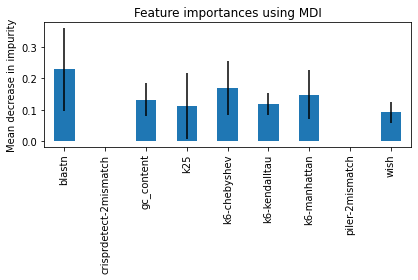

In [30]:
mf.draw_gini_importances(importances_means, stds_means, X_main)

Get the feats

In [31]:
pd.Series(data=importances_means, index=X_main.columns).sort_values(ascending=False)

blastn                    0.228954
k6-chebyshev              0.169987
k6-manhattan              0.147494
gc_content                0.132441
k6-kendalltau             0.117227
k25                       0.112187
wish                      0.091193
crisprdetect-2mismatch    0.000308
piler-2mismatch           0.000209
dtype: float64

In [32]:
feats = list(pd.Series(data=importances_means, index=X_main.columns).sort_values(ascending=False).index)[0:4]

In [33]:
mf.calculate_vif(feats)

,features,vif_Factor
0,blastn,1.127520
1,k6-chebyshev,3.029060
2,k6-manhattan,14.446460
3,gc_content,12.725326
4,y,1.134156


Train the model on feats

In [34]:
train_rfc_on_features(feats, 'rfc_4_highest_gini')

#### 3. Determine n feats with highest SHAP values

In [35]:
shap_vals = load('test/shap_values_rfc.joblib')

In [36]:
mean_shap_vals = np.mean([np.mean(np.absolute(i), axis=0) for i in shap_vals], axis=0)

In [37]:
feats = list(pd.Series(data=mean_shap_vals, index=X_main.columns).sort_values(ascending=False).index)[0:4]

In [38]:
mf.calculate_vif(feats)

,features,vif_Factor
0,blastn,8.832319
1,k25,8.831758
2,k6-chebyshev,3.025680
3,k6-manhattan,3.029516
4,y,1.133800


In [39]:
train_rfc_on_features(feats, 'rfc_4_highest_shap')

#### Visualise RFC PR curves

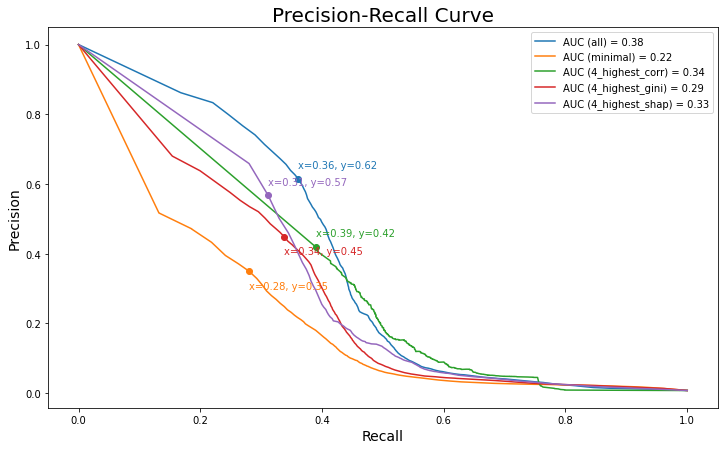

In [40]:
mf.draw_precision_recall_curve(
    [df_all_small, 
    results_dfs['rfc_minimal'], 
    results_dfs['rfc_4_highest_corr'], 
    results_dfs['rfc_4_highest_gini'], 
    results_dfs['rfc_4_highest_shap']
    ],
    ['rfc_all', 'rfc_minimal', 'rfc_4_highest_corr', 'rfc_4_highest_gini', 'rfc_4_highest_shap']
)

### Logistic Regression

Define function

In [33]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression

def train_lrc_on_features(features: list, name: str):
    # get X and y
    X_learning = learning_df[features]
    y_learning = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    logo = LeaveOneGroupOut()
    lrc = LogisticRegression(penalty='l2', C=0.001, solver='liblinear')

    # evaluate model
    results_lrc = cross_validate(lrc, X_learning, y_learning, scoring='f1', 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    
    # get probabilities and put them to the results dict
    results_dfs[name] = pd.concat([df_all_small['y'], \
            mf.get_probabilities(features, results_lrc, df_all_small)], axis=1)
    
    return

#### All features

In [34]:
train_lrc_on_features(X_main.columns, 'lrc_all')

#### Minimal set

In [35]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_lrc_on_features(feats, 'lrc_minimal')

In [47]:
mf.calculate_vif(['blastn', 'gc_content', 'k6-chebyshev'])

,features,vif_Factor
0,blastn,1.127404
1,gc_content,2.668067
2,k6-chebyshev,2.669262
3,y,1.128129


#### n most correlated with label

In [48]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])

In [49]:
mf.calculate_vif(feats)

,features,vif_Factor
0,k25,8.828372
1,blastn,8.831366
2,crisprdetect-2mismatch,6.661896
3,piler-2mismatch,6.658685
4,y,1.144898


In [ ]:
train_lrc_on_features(feats, 'lrc_4_highest_corr')

#### n highest SHAP values

In [50]:
shap_lrc = load('test/shap_values_lrc.joblib')
mean_shap_lrc = np.mean([np.absolute(val) for i in shap_lrc for val in i.values], axis=0)
feats = list(pd.Series(data=mean_shap_lrc, index=X_main.columns).sort_values(ascending=False).index)[0:4]

In [51]:
mf.calculate_vif(feats)

,features,vif_Factor
0,blastn,8.832412
1,k25,8.831760
2,k6-manhattan,37.444694
3,k6-kendalltau,37.456935
4,y,1.134575


In [ ]:
train_lrc_on_features(feats, 'lrc_4_highest_shap')

#### Visualise Logistic Regression

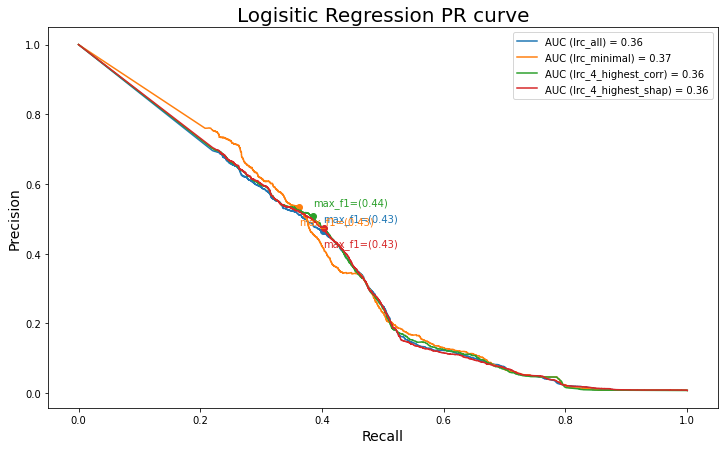

In [46]:
mf.draw_precision_recall_curve(
    dfs=[
        results_dfs['lrc_all'],
        results_dfs['lrc_minimal'],
        results_dfs['lrc_4_highest_corr'],
        results_dfs['lrc_4_highest_shap']
    ],
    names=['lrc_all', 'lrc_minimal', 'lrc_4_highest_corr', 'lrc_4_highest_shap'],
    plot_name='Logisitic Regression PR curve'
)

### LinearSVC

In [52]:
from sklearn.preprocessing import Normalizer

def get_probabilities_svc(features: list, results_selected):
    # get the probabilities
    X_sel_main = df_all_small[features]
    prob_df_sel = pd.DataFrame(index=range(len(df_all_small['y'])), columns=['0', '1'])
    prob_df_sel['0'] = prob_df_sel['0'].astype('float')
    prob_df_sel['1'] = prob_df_sel['1'].astype('float')
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        X_curr = Normalizer().fit_transform(X_sel_main.loc[mask_main,:])
        prob_df_sel.loc[mask_main, ['0', '1']] = \
            results_selected['estimator'][i].predict_proba(X_curr)

    return pd.concat([df_all_small['y'], prob_df_sel], axis=1)

In [18]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.calibration import CalibratedClassifierCV

def train_linsvc_on_features(features: list, name: str):
    # get X and y
    X_learning = learning_df[features]
    y_learning = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    logo = LeaveOneGroupOut()
    pipe = Pipeline([
        ('normalize', Normalizer()),
        ('svc', LinearSVC(C=0.01, class_weight={0:1, 1:1.5})),
    ])

    # evaluate model
    results_svc = cross_validate(pipe, X_learning.to_numpy(), y_learning, scoring='f1', 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # create Calibrated Classifier (to get access to predict_proba)
    for i,est in enumerate(results_svc['estimator']):
        results_svc['estimator'][i] = CalibratedClassifierCV(est, cv='prefit')
        results_svc['estimator'][i].fit(X_learning[learning_df['group_code'] == i].to_numpy(), y_learning[learning_df['group_code'] == i])

    # get probabilities
    prob_df_sel = mf.get_probabilities(features, results_svc, df_all_small, normalize=True)
    
    # get probabilities and put them to the results dict
    results_dfs[name] = pd.concat([df_all_small['y'], prob_df_sel], axis=1)
    
    return

#### All features

In [19]:
train_linsvc_on_features(X_main.columns, 'linSVC_all_normalizer')

#### Minimal set

In [20]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_linsvc_on_features(feats, 'linSVC_minimal_normalizer')

In [12]:
mf.calculate_vif(feats, df_all_small)

,features,vif_Factor
0,blastn,1.127404
1,gc_content,2.668067
2,k6-chebyshev,2.669262
3,y,1.128129


#### n most correlated with label

In [21]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_linsvc_on_features(feats, 'linSVC_4_highest_corr_normalizer')

In [15]:
mf.calculate_vif(feats, df_all_small)

,features,vif_Factor
0,k25,8.828372
1,blastn,8.831366
2,crisprdetect-2mismatch,6.661896
3,piler-2mismatch,6.658685
4,y,1.144898


In [22]:
results_dfs.keys()

dict_keys(['linSVC_all', 'linSVC_minimal', 'linSVC_4_highest_corr', 'linSVC_all_normalizer', 'linSVC_minimal_normalizer', 'linSVC_4_highest_corr_normalizer'])

#### Visualise LinearSVC

c:\licencjat\master_functions.py:150: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = np.divide(2*recall*precision, recall+precision)


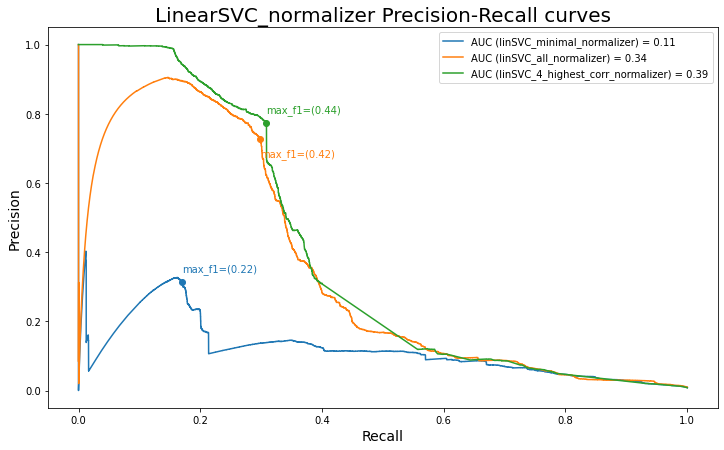

In [23]:
mf.draw_precision_recall_curve(
    dfs=[
    results_dfs['linSVC_minimal_normalizer'],
    results_dfs['linSVC_all_normalizer'],
    results_dfs['linSVC_4_highest_corr_normalizer']
    ],
    names=[
    'linSVC_minimal_normalizer',
    'linSVC_all_normalizer',
    'linSVC_4_highest_corr_normalizer'
    ],
    plot_name='LinearSVC_normalizer Precision-Recall curves'
)

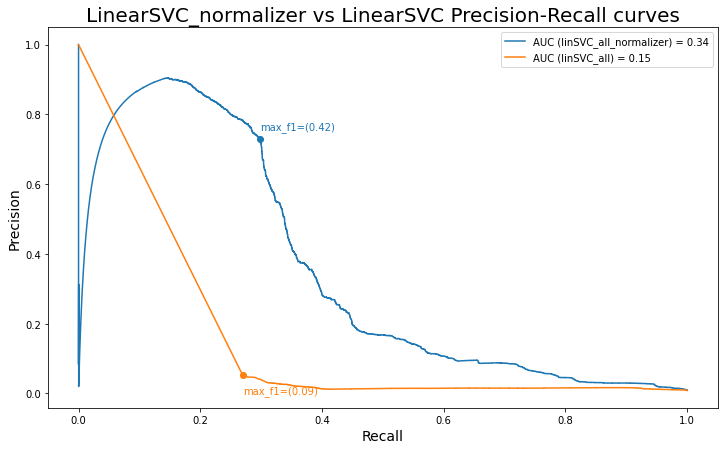

In [24]:
mf.draw_precision_recall_curve(
    dfs=[
    results_dfs['linSVC_all_normalizer'],
    results_dfs['linSVC_all']
    ],
    names=[
    'linSVC_all_normalizer',
    'linSVC_all'
    ],
    plot_name='LinearSVC_normalizer vs LinearSVC Precision-Recall curves'
)

In [25]:
df_linsvc_probs = df_all_small.copy()

In [28]:
results_dfs.keys()

dict_keys(['linSVC_all', 'linSVC_minimal', 'linSVC_4_highest_corr', 'linSVC_all_normalizer', 'linSVC_minimal_normalizer', 'linSVC_4_highest_corr_normalizer'])

In [32]:
df_linsvc_probs[['y','0', '1']] = results_dfs['linSVC_all']
orgs = mf.load_in_taxonomy_json()
mf.get_correct_preds_percentages(df_linsvc_probs, orgs, 'LinSVC_MinMaxScaler', report=True)

LinSVC_MinMaxScaler - num of preds with highest prob: 87473, mean = 106.67


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
LinSVC_MinMaxScaler,10.243902,20.243902,27.804878,36.585366,53.902439,61.707317,100.0


In [34]:
df_linsvc_probs_normalizer = df_all_small.copy()
df_linsvc_probs_normalizer[['y','0', '1']] = results_dfs['linSVC_all_normalizer']
mf.get_correct_preds_percentages(df_linsvc_probs_normalizer, orgs, 'LinSVC_MinMaxScaler', report=True)

LinSVC_MinMaxScaler - num of preds with highest prob: 820, mean = 1.00


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
LinSVC_MinMaxScaler,41.585366,51.097561,58.658537,62.317073,72.439024,80.97561,100.0


### SGD

In [87]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

def train_sgd_on_features(features: list, name: str):
    # get X and y
    X_learning = learning_df[features]
    y_learning = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    logo = LeaveOneGroupOut()
    pipe = Pipeline([
        ('normalize', Normalizer()),
        ('svc', SGDClassifier(alpha=0.005, loss='log', penalty='l1'))])

    # evaluate model
    results_sgd = cross_validate(pipe, X_learning, y_learning, scoring='f1', 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)
    
    # get probabilities and put them to the results dict
    results_dfs[name] = get_probabilities_svc(features, results_sgd)
    
    return

#### On all features

In [ ]:
feats = list(X_main.columns)
train_sgd_on_features(feats, 'SGD_all')

#### Minimal set

In [ ]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_sgd_on_features(feats, 'SGD_minimal')

#### n most correlated with label

In [ ]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_sgd_on_features(feats, 'SGD_4_highest_corr')

#### Visualise SGD

C:\Users\misia\AppData\Local\Temp\ipykernel_1708\2217512975.py:8: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = np.divide(2*recall*precision, recall+precision)


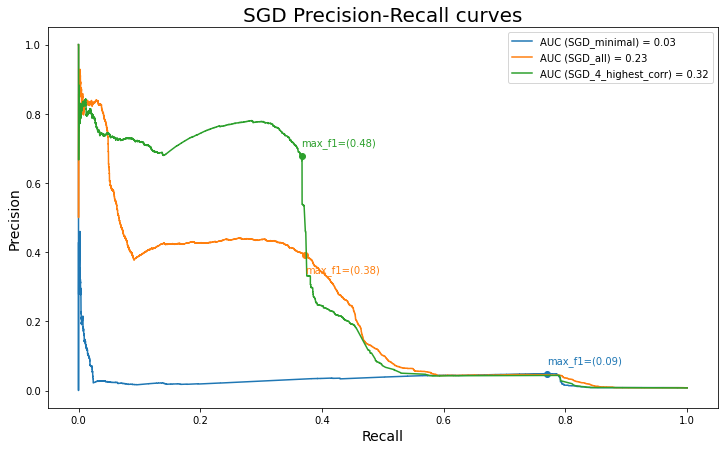

In [90]:
mf.draw_precision_recall_curve(
    dfs=[results_dfs['SGD_minimal'],
    results_dfs['SGD_all'],
    results_dfs['SGD_4_highest_corr']],
    names=['SGD_minimal',
    'SGD_all',
    'SGD_4_highest_corr'],
    plot_name='SGD Precision-Recall curves'
)

### KNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn_on_features(features: list, name: str):
    # get X and y
    X_learning = learning_df[features]
    y_learning = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    logo = LeaveOneGroupOut()
    pipe = Pipeline([
        ('normalize', Normalizer()),
        ('knn', KNeighborsClassifier(algorithm='kd_tree', leaf_size=5)),
    ])

    # evaluate model
    results_knn = cross_validate(pipe, X_learning, y_learning, scoring='f1', 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # get probabilities and put them to the results dict
    results_dfs[name] = get_probabilities_svc(features, results_knn)
    
    return

#### On all features

In [ ]:
feats = list(X_main.columns)
train_knn_on_features(feats, 'KNN_all')

#### Minimal set

In [ ]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_knn_on_features(feats, 'KNN_minimal')

#### n most correlated with label

In [ ]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_knn_on_features(feats, 'KNN_4_highest_corr')

#### Visualise KNN

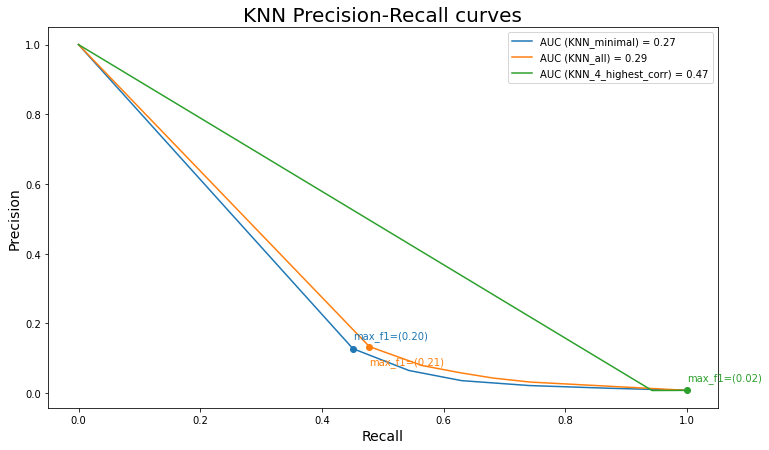

In [96]:
mf.draw_precision_recall_curve(
    dfs=[results_dfs['KNN_minimal'],
    results_dfs['KNN_all'],
    results_dfs['KNN_4_highest_corr']],
    names=['KNN_minimal',
    'KNN_all',
    'KNN_4_highest_corr'],
    plot_name='KNN Precision-Recall curves'
)

## PCA

In [16]:
from importlib import reload
reload(mf)

<module 'master_functions' from 'c:\\licencjat\\master_functions.py'>

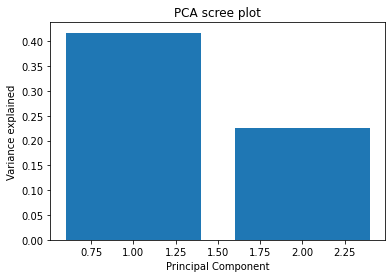

In [17]:
pca_df = mf.get_pca(X_main, df_all_small['y'], 2, scree_plot=True)

Visualize PCA

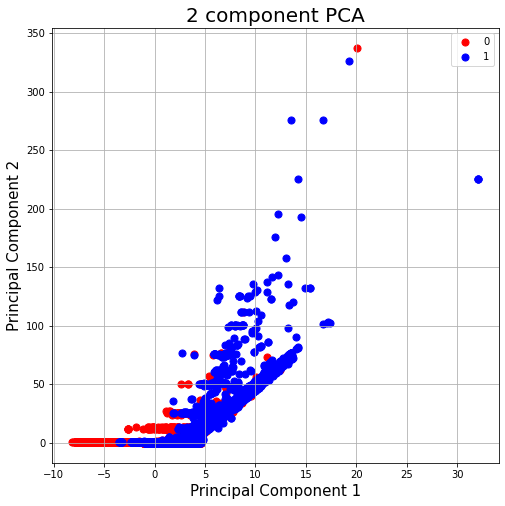

In [18]:
mf.draw_pca_2d(pca_df)

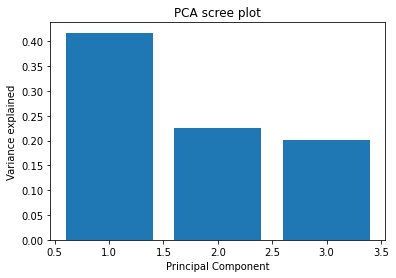

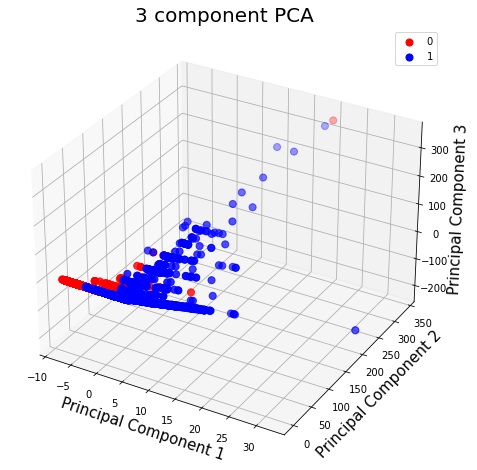

In [19]:
mf.draw_pca_3d(mf.get_pca(X_main, df_all_small['y'], 3, scree_plot=True))

### Random Forest

In [20]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

def train_rfc_on_features_pca(features: list, name: str, comps: int, n_est=200):
    # get X and y
    X_selected = learning_df[features]
    y_selected = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    # train the model
    # determine the scoring method
    scoring = ['f1']
    # create logo cv procedure
    logo = LeaveOneGroupOut()
    # create model
    pipe = Pipeline([
        ('stadardize', StandardScaler()),
        ('pca', PCA(n_components=comps)),
        ('rfc', RandomForestClassifier(n_estimators = n_est, criterion = 'entropy', 
                                max_depth=4, random_state=1) )
    ])
    
    # evaluate model
    results_selected = cross_validate(pipe, X_selected, y_selected, scoring=scoring, 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # get the probabilities
    prob_df_sel = mf.get_probabilities(features, results_selected, df_all_small)
    '''
    X_sel_main = df_all_small[features]
    prob_df_sel = pd.DataFrame(index=range(len(df_all_small['y'])), columns=['0', '1'])
    prob_df_sel['0'] = prob_df_sel['0'].astype('float')
    prob_df_sel['1'] = prob_df_sel['1'].astype('float')
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        # X_curr = PCA(n_components=comps).fit_transform(X_sel_main.iloc[mask_main,:])
        prob_df_sel.loc[mask_main, ['0', '1']] = \
            results_selected['estimator'][i].predict_proba(X_sel_main.iloc[mask_main,:])
    '''

    # append the dataframe to results dict
    results_dfs[name] = pd.concat([df_all_small['y'], prob_df_sel], axis=1)
    return

#### 2 components

##### On all features

In [23]:
feats = list(X_main.columns)
train_rfc_on_features_pca(feats, 'rfc_pca_2D', 2)

##### n most correlated with label

In [24]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_rfc_on_features_pca(feats, 'rfc_pca_4_highest_corr_2D', 2)

##### Minimal set

In [25]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_rfc_on_features_pca(feats, 'rfc_pca_minimal_2D', 2)

##### Visualise RFC_PCA 2D

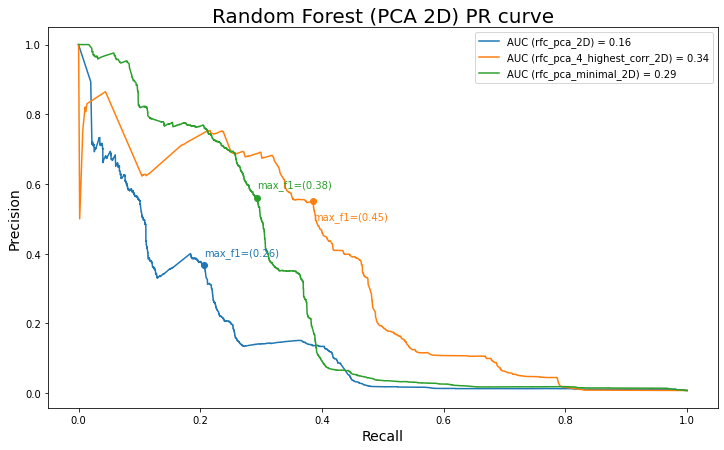

In [26]:
mf.draw_precision_recall_curve(
    dfs=[results_dfs['rfc_pca_2D'],
    results_dfs['rfc_pca_4_highest_corr_2D'],
    results_dfs['rfc_pca_minimal_2D']],
    names=['rfc_pca_2D', 'rfc_pca_4_highest_corr_2D', 'rfc_pca_minimal_2D'], 
    plot_name='Random Forest (PCA 2D) PR curve'
)

#### 3 components

##### All features

In [16]:
feats = list(X_main.columns)
train_rfc_on_features_pca(feats, 'rfc_pca_3D', 3)

##### Minimal set

In [17]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_rfc_on_features_pca(feats, 'rfc_pca_minimal_3D', 3)

##### n most correlated label

In [18]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_rfc_on_features_pca(feats, 'rfc_pca_4_highest_corr_3D', 3)

##### Visualise RFC PCA 3D PR curve

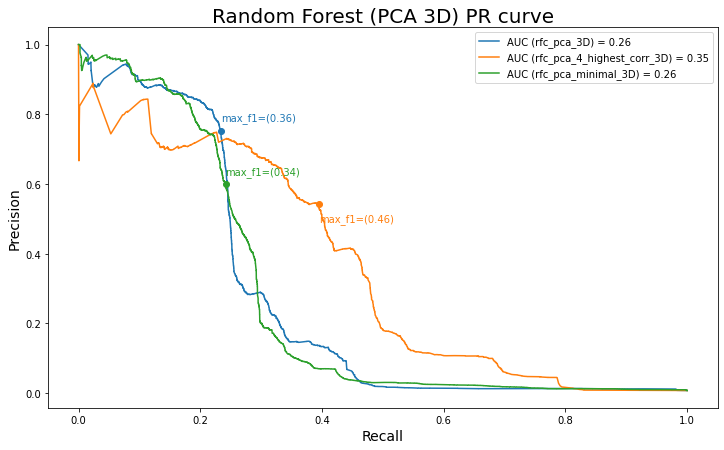

In [19]:
mf.draw_precision_recall_curve(
    dfs=[results_dfs['rfc_pca_3D'],
    results_dfs['rfc_pca_4_highest_corr_3D'],
    results_dfs['rfc_pca_minimal_3D']],
    names=['rfc_pca_3D', 'rfc_pca_4_highest_corr_3D', 'rfc_pca_minimal_3D'], 
    plot_name='Random Forest (PCA 3D) PR curve'
)

### LinearSVC

In [53]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA

def train_linsvc_on_features_pca(features: list, name: str, n_comp: int):
    # get X and y
    X_learning = learning_df[features]
    y_learning = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    logo = LeaveOneGroupOut()
    pipe = Pipeline([
        ('normalize', Normalizer()),
        ('pca', PCA(n_components=n_comp)),
        ('svc', LinearSVC(C=0.01, class_weight={0:1, 1:1.5})),
    ])

    # evaluate model
    results_svc = cross_validate(pipe, X_learning, y_learning, scoring='f1', 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # create Calibrated Classifier (to get access to predict_proba)
    for i,est in enumerate(results_svc['estimator']):
        results_svc['estimator'][i] = CalibratedClassifierCV(est, cv='prefit')
        results_svc['estimator'][i].fit(X_learning[learning_df['group_code'] == i], y_learning[learning_df['group_code'] == i])
    
    # get probabilities and put them to the results dict
    results_dfs[name] = get_probabilities_svc(features, results_svc)
    
    return

#### 2 components

##### All features

In [ ]:
feats = list(X_main.columns)
train_linsvc_on_features_pca(feats, 'linsvc_pca_all_2D', 2)

##### n most correlated with label

In [ ]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_linsvc_on_features_pca(feats, 'linsv_pca_4_highest_corr_2D', 2)

##### Minimal set

In [ ]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_linsvc_on_features_pca(feats, 'linsvc_pca_minimal_2D', 2)

##### Visualise LinSVC PCA 2D PR curve

invalid value encountered in true_divide
invalid value encountered in true_divide


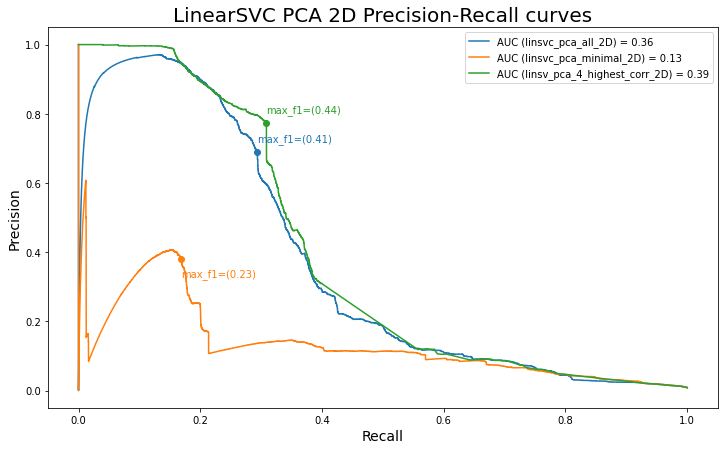

In [57]:
mf.draw_precision_recall_curve(
    dfs=[
        results_dfs['linsvc_pca_all_2D'],
        results_dfs['linsvc_pca_minimal_2D'],
        results_dfs['linsv_pca_4_highest_corr_2D']
    ],
    names=['linsvc_pca_all_2D', 
    'linsvc_pca_minimal_2D', 
    'linsv_pca_4_highest_corr_2D'],
    plot_name='LinearSVC PCA 2D Precision-Recall curves'
)

#### 3 components

##### All features

In [ ]:
feats = list(X_main.columns)
train_linsvc_on_features_pca(feats, 'linsvc_pca_all_3D', 3)

##### n most correlated with label

In [ ]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
train_linsvc_on_features_pca(feats, 'linsv_pca_4_highest_corr_3D', 3)

##### Minimal set

In [ ]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_linsvc_on_features_pca(feats, 'linsvc_pca_minimal_3D', 3)

##### Visualise LinSVC PCA 3D PR curve

invalid value encountered in true_divide


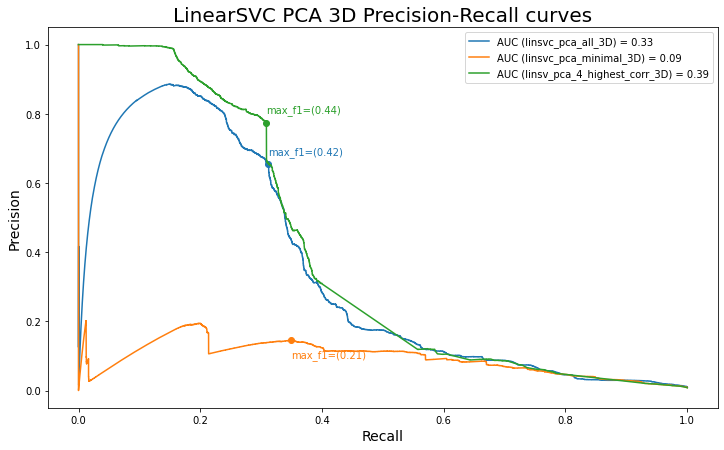

In [61]:
mf.draw_precision_recall_curve(
    dfs=[
        results_dfs['linsvc_pca_all_3D'],
        results_dfs['linsvc_pca_minimal_3D'],
        results_dfs['linsv_pca_4_highest_corr_3D']
    ],
    names=['linsvc_pca_all_3D', 
    'linsvc_pca_minimal_3D', 
    'linsv_pca_4_highest_corr_3D'],
    plot_name='LinearSVC PCA 3D Precision-Recall curves'
)